In [318]:
import os
import time
import pandas as pd
import numpy as np
import numpy.random as npr
import copy
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma
from scipy.sparse import csr_matrix
from typing import List, Dict, Tuple, Set, Optional

In [319]:
def log_sum_exp(vec):
    vec_max = np.max(vec, axis=0)
    exp_vec = np.exp(vec - vec_max)
    sum_exp_vec = np.sum(exp_vec)
    log_sum_exp = np.log(sum_exp_vec) + vec_max
    return log_sum_exp

def init_variational_params(documents, K):
    N, V = documents.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for document in documents:
        M = np.sum((document > 0).astype("int32"))
        document_PHI = np.ones((M, K))
        document_PHI = document_PHI / K
        PHI.append(document_PHI)
        
    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K):
    ELBO = 0
    N, _ = documents.shape

    E_log_p_BETA = np.sum((ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum((ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))
    ELBO += E_log_p_THETA

    E_log_p_x_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_p_x_z += document[idx] * np.sum(PHI[i][word_idx] * (digamma(GAMMA[i])-digamma(np.sum(GAMMA[i])))) \
                + document[idx] * np.sum(PHI[i][word_idx] * (digamma(LAMBDA[:, idx])-digamma(np.sum(LAMBDA, axis=1))))
            word_idx += 1
    ELBO += E_log_p_x_z

    E_log_q_BETA = np.sum(-loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_BETA

    E_log_q_THETA = np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_THETA

    E_log_q_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -document[idx] * np.sum(PHI[i][word_idx] * np.log(PHI[i][word_idx]))
            word_idx += 1
    ELBO += E_log_q_z

    return ELBO

In [341]:
def simulate_LDA(N, avg_doc_length, K, V, ETA, ALPHA, rs_int=np.random.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int) 
    BETA = rs.dirichlet(np.full(V, ETA), size=K)
    THETA = rs.dirichlet(np.full(K, ALPHA), size=N)
    doc_lengths = rs.poisson(avg_doc_length, size=N)
    
    row_idxs = []
    col_idxs = []
    values = []
    nonzero_idxs = []

    for i in range(N):
        doc_word_counts = np.zeros(V)
        for _ in range(doc_lengths[i]):
            z_ij = rs.choice(K, p=THETA[i])
            x_ij = rs.choice(V, p=BETA[z_ij])
            doc_word_counts[x_ij] += 1
        doc_nonzero = np.nonzero(doc_word_counts)[0]
        doc_nonzero = np.array(sorted(doc_nonzero))
        nonzero_idxs.append(doc_nonzero)

        row_idxs.extend([i] * len(doc_nonzero))
        col_idxs.extend(doc_nonzero)
        values.extend(doc_word_counts[doc_nonzero])
    documents = csr_matrix((values, (row_idxs, col_idxs)), shape=(N, V)).toarray()
    
    return documents, nonzero_idxs, BETA, THETA

In [343]:
N = 100
avg_doc_length = 100
K = 10
V = 1000
ETA = 100 / V
ALPHA = 1 / K
documents, nonzero_idxs, BETA, THETA = simulate_LDA(N, avg_doc_length, K, V, ETA, ALPHA)
LAMBDA, GAMMA, PHI = init_variational_params(documents, K)

Initial ELBO: -101662.60548352466

Iteration 1


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 106.74it/s]


Current ELBO: -58055.83904342602 | Change in ELBO: 43606.76644009864

Iteration 2


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 106.45it/s]


Current ELBO: -57130.46900401279 | Change in ELBO: 925.370039413232

Iteration 3


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 95.20it/s]


Current ELBO: -56185.511807514704 | Change in ELBO: 944.957196498086

Iteration 4


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 102.25it/s]


Current ELBO: -55176.459017936104 | Change in ELBO: 1009.0527895785999

Iteration 5


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.40it/s]


Current ELBO: -54057.65600585552 | Change in ELBO: 1118.8030120805852

Iteration 6


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 103.60it/s]


Current ELBO: -52857.59988395906 | Change in ELBO: 1200.0561218964576

Iteration 7


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 113.82it/s]


Current ELBO: -51718.70087135352 | Change in ELBO: 1138.8990126055432

Iteration 8


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 112.97it/s]


Current ELBO: -50736.10772284792 | Change in ELBO: 982.593148505599

Iteration 9


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 74.16it/s]


Current ELBO: -49964.09241119561 | Change in ELBO: 772.015311652307

Iteration 10


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 121.64it/s]


Current ELBO: -49396.64827056596 | Change in ELBO: 567.4441406296537

Iteration 11


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 79.64it/s]


Current ELBO: -48995.70468921037 | Change in ELBO: 400.94358135559014

Iteration 12


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 106.28it/s]


Current ELBO: -48702.26286367045 | Change in ELBO: 293.4418255399214

Iteration 13


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 103.13it/s]


Current ELBO: -48479.14573521453 | Change in ELBO: 223.11712845591683

Iteration 14


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 101.25it/s]


Current ELBO: -48310.47473316223 | Change in ELBO: 168.67100205230236

Iteration 15


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 82.91it/s]


Current ELBO: -48184.946995733866 | Change in ELBO: 125.52773742836143

Iteration 16


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 73.19it/s]


Current ELBO: -48091.818628338326 | Change in ELBO: 93.12836739554041

Iteration 17


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 86.85it/s]


Current ELBO: -48018.000046879955 | Change in ELBO: 73.81858145837032

Iteration 18


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 72.44it/s]


Current ELBO: -47956.74715977109 | Change in ELBO: 61.25288710886525

Iteration 19


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 97.38it/s]


Current ELBO: -47909.78962159606 | Change in ELBO: 46.95753817503282

Iteration 20


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 120.32it/s]


Current ELBO: -47875.94090864625 | Change in ELBO: 33.84871294980985

Iteration 21


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 67.42it/s]


Current ELBO: -47851.90697877799 | Change in ELBO: 24.033929868259293

Iteration 22


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 97.08it/s]


Current ELBO: -47832.67784182956 | Change in ELBO: 19.229136948430096

Iteration 23


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 113.56it/s]


Current ELBO: -47815.681560552766 | Change in ELBO: 16.996281276791706

Iteration 24


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 89.83it/s]


Current ELBO: -47800.536242304705 | Change in ELBO: 15.145318248061812

Iteration 25


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 117.09it/s]


Current ELBO: -47786.21163696736 | Change in ELBO: 14.32460533734411

Iteration 26


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 73.46it/s]


Current ELBO: -47772.316694767615 | Change in ELBO: 13.894942199745856

Iteration 27


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 49.16it/s]


Current ELBO: -47760.04779317304 | Change in ELBO: 12.268901594572526

Iteration 28


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 116.40it/s]


Current ELBO: -47749.227173632215 | Change in ELBO: 10.820619540827465

Iteration 29


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 96.22it/s]


Current ELBO: -47740.09071373901 | Change in ELBO: 9.136459893205028

Iteration 30


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 89.40it/s]


Current ELBO: -47732.71414700028 | Change in ELBO: 7.376566738726979

Iteration 31


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 83.10it/s]


Current ELBO: -47727.2742940683 | Change in ELBO: 5.4398529319805675

Iteration 32


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 114.77it/s]


Current ELBO: -47721.88059145385 | Change in ELBO: 5.393702614448557

Iteration 33


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 115.09it/s]


Current ELBO: -47716.64572220684 | Change in ELBO: 5.234869247011375

Iteration 34


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 115.98it/s]


Current ELBO: -47713.02329911242 | Change in ELBO: 3.6224230944208102

Iteration 35


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 79.01it/s]


Current ELBO: -47710.821084129224 | Change in ELBO: 2.2022149831973366

Iteration 36


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 121.31it/s]


Current ELBO: -47708.535651801125 | Change in ELBO: 2.2854323280989775

Iteration 37


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 116.47it/s]


Current ELBO: -47706.51097304074 | Change in ELBO: 2.0246787603828125

Iteration 38


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.38it/s]


Current ELBO: -47705.15558164796 | Change in ELBO: 1.3553913927826216

Iteration 39


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 108.84it/s]


Current ELBO: -47704.09460150503 | Change in ELBO: 1.06098014293093

Iteration 40


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.27it/s]


Current ELBO: -47702.96316959717 | Change in ELBO: 1.1314319078592234

Iteration 41


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 107.03it/s]


Current ELBO: -47701.73340653411 | Change in ELBO: 1.2297630630564527

Iteration 42


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 93.16it/s]


Current ELBO: -47700.13695182483 | Change in ELBO: 1.5964547092808061

Iteration 43


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 110.98it/s]


Current ELBO: -47698.809471855595 | Change in ELBO: 1.3274799692371744

Iteration 44


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 87.31it/s]


Current ELBO: -47697.33235247482 | Change in ELBO: 1.477119380775548

Iteration 45


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 98.79it/s]


Current ELBO: -47695.485616870996 | Change in ELBO: 1.8467356038236176

Iteration 46


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 90.37it/s]


Current ELBO: -47694.29690322022 | Change in ELBO: 1.1887136507721152

Iteration 47


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 122.65it/s]


Current ELBO: -47693.57731840145 | Change in ELBO: 0.7195848187766387

Iteration 48


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 105.60it/s]


Current ELBO: -47693.05491390274 | Change in ELBO: 0.5224044987044181

Iteration 49


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 100.42it/s]


Current ELBO: -47692.31331837263 | Change in ELBO: 0.7415955301112263

Iteration 50


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 103.47it/s]


Current ELBO: -47691.61693464774 | Change in ELBO: 0.6963837248913478

Iteration 51


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 105.43it/s]


Current ELBO: -47690.811981881336 | Change in ELBO: 0.8049527664043126

Iteration 52


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.05it/s]


Current ELBO: -47689.78129730984 | Change in ELBO: 1.0306845714949304

Iteration 53


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 115.55it/s]


Current ELBO: -47688.927396733874 | Change in ELBO: 0.8539005759666907

Iteration 54


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 69.57it/s]


Current ELBO: -47687.905743163916 | Change in ELBO: 1.0216535699582892

Iteration 55


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 117.94it/s]


Current ELBO: -47686.34957095095 | Change in ELBO: 1.5561722129641566

Iteration 56


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 116.01it/s]


Current ELBO: -47685.49212418714 | Change in ELBO: 0.8574467638100032

Iteration 57


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 71.17it/s]


Current ELBO: -47684.88432781844 | Change in ELBO: 0.6077963686984731

Iteration 58


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 92.22it/s]


Current ELBO: -47684.261880133025 | Change in ELBO: 0.6224476854185923

Iteration 59


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 120.25it/s]


Current ELBO: -47683.87269904563 | Change in ELBO: 0.3891810873974464

Iteration 60


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 112.73it/s]


Current ELBO: -47683.27121565322 | Change in ELBO: 0.6014833924054983

Iteration 61


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 97.49it/s]


Current ELBO: -47682.480137844876 | Change in ELBO: 0.7910778083460173

Iteration 62


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 127.17it/s]


Current ELBO: -47681.742900089645 | Change in ELBO: 0.7372377552310354

Iteration 63


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 102.44it/s]


Current ELBO: -47680.940953655416 | Change in ELBO: 0.8019464342287392

Iteration 64


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 118.25it/s]


Current ELBO: -47680.32339973346 | Change in ELBO: 0.6175539219548227

Iteration 65


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 112.66it/s]


Current ELBO: -47679.64476944242 | Change in ELBO: 0.6786302910404629

Iteration 66


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 116.72it/s]


Current ELBO: -47678.89765761058 | Change in ELBO: 0.7471118318426306

Iteration 67


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 113.92it/s]


Current ELBO: -47677.981203694646 | Change in ELBO: 0.9164539159319247

Iteration 68


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 103.97it/s]


Current ELBO: -47676.56900449133 | Change in ELBO: 1.4121992033178685

Iteration 69


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 119.27it/s]


Current ELBO: -47675.914250275906 | Change in ELBO: 0.6547542154221446

Iteration 70


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 113.42it/s]


Current ELBO: -47675.77855591204 | Change in ELBO: 0.13569436386751477

Iteration 71


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 123.23it/s]


Current ELBO: -47675.554867087674 | Change in ELBO: 0.223688824364217

Iteration 72


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 103.29it/s]


Current ELBO: -47675.160074026215 | Change in ELBO: 0.3947930614594952

Iteration 73


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 77.36it/s]


Current ELBO: -47674.89293077064 | Change in ELBO: 0.26714325557259144

Iteration 74


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 102.66it/s]


Current ELBO: -47674.7716516454 | Change in ELBO: 0.12127912524010753

Iteration 75


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 105.48it/s]


Current ELBO: -47674.58584737321 | Change in ELBO: 0.18580427219421836

Iteration 76


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 89.38it/s]


Current ELBO: -47674.25045641676 | Change in ELBO: 0.33539095644664485

Iteration 77


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 68.51it/s]


Current ELBO: -47673.80378731257 | Change in ELBO: 0.4466691041889135

Iteration 78


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 118.81it/s]


Current ELBO: -47673.561141078164 | Change in ELBO: 0.242646234408312

Iteration 79


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 97.27it/s]


Current ELBO: -47673.246386285806 | Change in ELBO: 0.3147547923581442

Iteration 80


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 89.15it/s]


Current ELBO: -47672.74768227277 | Change in ELBO: 0.49870401303633116

Iteration 81


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 108.19it/s]


Current ELBO: -47672.42146894056 | Change in ELBO: 0.3262133322059526

Iteration 82


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 104.48it/s]


Current ELBO: -47672.35360415529 | Change in ELBO: 0.06786478527646977

Iteration 83


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 95.95it/s]


Current ELBO: -47672.27585810394 | Change in ELBO: 0.07774605134909507

Iteration 84


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 119.47it/s]


Current ELBO: -47672.17366772552 | Change in ELBO: 0.10219037842034595

Iteration 85


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 113.51it/s]


Current ELBO: -47672.02958400605 | Change in ELBO: 0.14408371946774423

Iteration 86


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 94.98it/s]


Current ELBO: -47671.806673108425 | Change in ELBO: 0.22291089762438787

Iteration 87


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 114.05it/s]


Current ELBO: -47671.430538764645 | Change in ELBO: 0.3761343437799951

Iteration 88


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 123.00it/s]


Current ELBO: -47670.97386154038 | Change in ELBO: 0.45667722426878754

Iteration 89


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.38it/s]


Current ELBO: -47670.901550930575 | Change in ELBO: 0.07231060980120674

Iteration 90


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 82.76it/s]


Current ELBO: -47670.898852491235 | Change in ELBO: 0.002698439340747427

Iteration 91


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.58it/s]


Current ELBO: -47670.89635070876 | Change in ELBO: 0.0025017824737005867

Iteration 92


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.25it/s]


Current ELBO: -47670.89372984797 | Change in ELBO: 0.002620860788738355

Iteration 93


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 102.99it/s]


Current ELBO: -47670.89073921905 | Change in ELBO: 0.0029906289200880565

Iteration 94


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 93.73it/s]


Current ELBO: -47670.88699230778 | Change in ELBO: 0.0037469112721737474

Iteration 95


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 100.11it/s]


Current ELBO: -47670.88174597752 | Change in ELBO: 0.005246330263616983

Iteration 96


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 105.24it/s]


Current ELBO: -47670.87334962573 | Change in ELBO: 0.008396351789997425

Iteration 97


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 107.60it/s]


Current ELBO: -47670.857636279754 | Change in ELBO: 0.01571334597247187

Iteration 98


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 103.67it/s]


Current ELBO: -47670.82269263086 | Change in ELBO: 0.03494364889047574

Iteration 99


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 108.96it/s]


Current ELBO: -47670.7324173527 | Change in ELBO: 0.09027527816215297

Iteration 100


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 92.91it/s]


Current ELBO: -47670.52282274086 | Change in ELBO: 0.2095946118424763

Iteration 101


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 113.96it/s]


Current ELBO: -47670.379306441115 | Change in ELBO: 0.14351629974407842

Iteration 102


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 89.61it/s]


Current ELBO: -47670.3718753256 | Change in ELBO: 0.00743111551128095

Iteration 103


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 108.93it/s]


Current ELBO: -47670.36849374107 | Change in ELBO: 0.003381584530870896

Iteration 104


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 100.88it/s]


Current ELBO: -47670.36486862174 | Change in ELBO: 0.0036251193305361085

Iteration 105


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 96.73it/s]


Current ELBO: -47670.36080407761 | Change in ELBO: 0.0040645441331434995

Iteration 106


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 91.73it/s]


Current ELBO: -47670.3560978036 | Change in ELBO: 0.0047062740122783

Iteration 107


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 66.49it/s]


Current ELBO: -47670.350492305035 | Change in ELBO: 0.0056054985616356134

Iteration 108


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 88.32it/s]


Current ELBO: -47670.343628149356 | Change in ELBO: 0.0068641556790680625

Iteration 109


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 92.85it/s]


Current ELBO: -47670.33497384665 | Change in ELBO: 0.008654302706418093

Iteration 110


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 89.38it/s]


Current ELBO: -47670.323705219766 | Change in ELBO: 0.01126862688397523

Iteration 111


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 94.66it/s]


Current ELBO: -47670.30848185313 | Change in ELBO: 0.015223366637656

Iteration 112


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 89.36it/s]


Current ELBO: -47670.287004946425 | Change in ELBO: 0.021476906702446286

Iteration 113


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 98.16it/s]


Current ELBO: -47670.25507865023 | Change in ELBO: 0.03192629619297804

Iteration 114


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 90.81it/s]


Current ELBO: -47670.204450036 | Change in ELBO: 0.0506286142335739

Iteration 115


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 107.44it/s]


Current ELBO: -47670.11740203271 | Change in ELBO: 0.08704800328996498

Iteration 116


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 88.28it/s]


Current ELBO: -47669.9527941174 | Change in ELBO: 0.1646079153069877

Iteration 117


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 50.27it/s]


Current ELBO: -47669.62787624471 | Change in ELBO: 0.32491787269100314

Iteration 118


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 93.37it/s]


Current ELBO: -47669.26012803822 | Change in ELBO: 0.3677482064886135

Iteration 119


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 77.03it/s]


Current ELBO: -47669.21976444579 | Change in ELBO: 0.040363592430367135

Iteration 120


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 102.42it/s]


Current ELBO: -47669.214987532556 | Change in ELBO: 0.004776913236128166

Iteration 121


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 88.86it/s]


Current ELBO: -47669.20966734629 | Change in ELBO: 0.005320186268363614

Iteration 122


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 102.85it/s]


Current ELBO: -47669.203503000994 | Change in ELBO: 0.00616434529365506

Iteration 123


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 105.62it/s]


Current ELBO: -47669.19621711538 | Change in ELBO: 0.0072858856146922335

Iteration 124


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 111.64it/s]


Current ELBO: -47669.18746875814 | Change in ELBO: 0.008748357242438942

Iteration 125


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 101.54it/s]


Current ELBO: -47669.17680357108 | Change in ELBO: 0.010665187059203163

Iteration 126


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 108.65it/s]


Current ELBO: -47669.16359157738 | Change in ELBO: 0.01321199369704118

Iteration 127


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 97.73it/s]


Current ELBO: -47669.146933004595 | Change in ELBO: 0.01665857278567273

Iteration 128


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 108.35it/s]


Current ELBO: -47669.1255036036 | Change in ELBO: 0.021429400992929004

Iteration 129


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 101.14it/s]


Current ELBO: -47669.09728601998 | Change in ELBO: 0.028217583618243225

Iteration 130


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 95.10it/s]


Current ELBO: -47669.05907528062 | Change in ELBO: 0.03821073936705943

Iteration 131


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 106.15it/s]


Current ELBO: -47669.00550287661 | Change in ELBO: 0.053572404009173624

Iteration 132


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 93.92it/s]


Current ELBO: -47668.92694066821 | Change in ELBO: 0.07856220840039896

Iteration 133


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 110.13it/s]


Current ELBO: -47668.80454907725 | Change in ELBO: 0.12239159095770447

Iteration 134


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 79.78it/s]


Current ELBO: -47668.59793063892 | Change in ELBO: 0.2066184383293148

Iteration 135


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 112.69it/s]


Current ELBO: -47668.22816014922 | Change in ELBO: 0.36977048969856696

Iteration 136


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 93.63it/s]


Current ELBO: -47667.80262874515 | Change in ELBO: 0.42553140407108003

Iteration 137


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 130.31it/s]


Current ELBO: -47667.75069016085 | Change in ELBO: 0.0519385842999327

Iteration 138


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 135.00it/s]


Current ELBO: -47667.74946214923 | Change in ELBO: 0.001228011620696634

Iteration 139


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 118.25it/s]


Current ELBO: -47667.74871353846 | Change in ELBO: 0.0007486107715521939



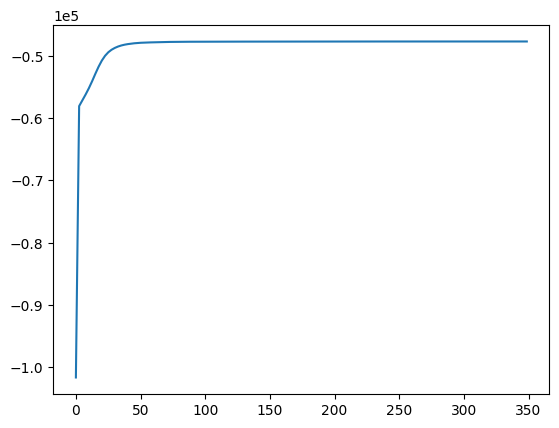

In [344]:
start = time.time()
ELBOs = []
prev_ELBO = -np.inf
curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K)
ELBOs.append(curr_ELBO)
print(f"Initial ELBO: {ELBOs[0]}\n")

max_iterations = 200
tol = 10e-4
LAMBDA_t = copy.deepcopy(LAMBDA)
GAMMA_t = copy.deepcopy(GAMMA)
PHI_t = copy.deepcopy(PHI)

for t in range(max_iterations):
    print(f"Iteration {t+1}")
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        GAMMA_i_t = copy.deepcopy(GAMMA_t[i])
        word_idx = 0
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((K,))
            for k in range(K):
                LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k])
                exp_propto = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t)) + digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                log_PHI_ij[k] = exp_propto
            PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
            PHI_t[i][word_idx] = PHI_ij
            word_idx += 1
        GAMMA_i_t = np.zeros((K,)) + ALPHA
        for k in range(K):
            GAMMA_i_t[k] += np.sum(document[nonzero_idx] * PHI_t[i][:, k])
        GAMMA_t[i] = GAMMA_i_t

    for k in tqdm(range(K), desc="Updating LAMBDA"):
        LAMBDA_k_t = np.zeros((V,)) + ETA
        for i in range(N):
            document = documents[i]
            nonzero_idx = nonzero_idxs[i]
            word_idx = 0
            for idx in nonzero_idx:
                LAMBDA_k_t[idx] += document[idx] * PHI_t[i][word_idx][k]
                word_idx += 1
            LAMBDA_t[k] = LAMBDA_k_t

    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA_t, GAMMA_t, PHI_t, documents, nonzero_idxs, K)
    ELBOs.append(curr_ELBO)
    print(f"Current ELBO: {curr_ELBO} | Change in ELBO: {curr_ELBO - prev_ELBO}\n")

    if abs(curr_ELBO - prev_ELBO) < tol:
        break
stop = time.time()

LAMBDA_final = copy.deepcopy(LAMBDA_t)
GAMMA_final = copy.deepcopy(GAMMA_t)
PHI_final = copy.deepcopy(PHI_t)

plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.plot(np.linspace(0, stop-start, len(ELBOs)), ELBOs)

In [347]:
LAMBDA_norm = LAMBDA_final / np.sum(LAMBDA_final, axis=1, keepdims=True)
LAMBDA_norm[0]

array([7.63691006e-05, 7.63894879e-05, 7.63863854e-05, 7.64006659e-05,
       2.37388297e-03, 7.63820158e-05, 2.02667016e-02, 7.63871094e-05,
       7.63691006e-05, 7.63792517e-05, 7.63806114e-05, 7.63743099e-05,
       1.00041633e-02, 7.64299680e-05, 7.63964804e-05, 7.63691006e-05,
       7.63868651e-05, 7.63691006e-05, 7.63919826e-05, 7.63907395e-05,
       7.63878054e-05, 7.63844541e-05, 7.63738372e-05, 7.63960307e-05,
       7.63691006e-05, 7.63761337e-05, 7.63857154e-05, 7.63691006e-05,
       4.65835119e-03, 7.63850973e-05, 7.64263217e-05, 9.87340302e-04,
       7.63938218e-05, 7.63973554e-05, 3.13098613e-03, 7.64032881e-05,
       7.63891107e-05, 1.60360493e-03, 7.63954567e-05, 7.63691006e-05,
       7.63891461e-05, 7.63691006e-05, 7.63995538e-05, 7.63904336e-05,
       7.63988926e-05, 7.63907749e-05, 7.63691006e-05, 7.63939815e-05,
       7.65093104e-05, 7.63742447e-05, 7.63820227e-05, 7.64097360e-05,
       7.65026136e-05, 7.64505695e-05, 5.48771457e-03, 7.63862948e-05,
      

In [346]:
BETA[0]

array([8.56031327e-04, 1.53142277e-03, 1.41409500e-02, 7.42729949e-05,
       1.25051553e-04, 2.94825707e-17, 4.97555058e-15, 5.49216527e-07,
       1.29271117e-08, 5.77470380e-23, 7.60241476e-03, 1.16838758e-07,
       1.15547663e-17, 1.03891911e-04, 2.67543273e-23, 1.57183526e-04,
       6.85034433e-06, 6.73441549e-52, 3.55282784e-04, 2.81252098e-08,
       4.62049587e-03, 4.30351841e-06, 6.52476390e-07, 2.44418994e-04,
       2.64671465e-11, 8.43170942e-09, 5.12466982e-03, 6.07989996e-09,
       3.02021114e-05, 1.84348987e-03, 4.30694631e-11, 8.55039025e-06,
       2.48794304e-02, 1.01326592e-05, 4.31151738e-03, 3.77330498e-09,
       2.35056701e-11, 5.92158552e-05, 9.46937703e-03, 1.34536650e-11,
       1.17488263e-09, 2.69365666e-06, 1.18740503e-02, 1.95277743e-03,
       2.57484945e-12, 1.15968348e-02, 1.43614208e-13, 1.42679223e-04,
       2.85080936e-04, 2.88702600e-08, 1.97867744e-03, 2.54657674e-04,
       1.29447357e-09, 5.91546230e-04, 9.28311057e-12, 3.07287446e-08,
      